# Part 3：用户活跃度预测模型（Optional）

本部分基于用户表 `users` 和事件表 `events`，构造用户行为特征，并训练一个简单的分类模型，
预测用户是否为“活跃用户”（active user），并分析影响活跃度的关键因素。


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

plt.rcParams["figure.figsize"] = (6, 4)


d:\an\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
d:\an\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
d:\an\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically 

## 1. 读取数据并与 Part 1 对齐

这里与 Part 1 使用相同的数据源，保持路径一致。


In [3]:
users = pd.read_csv("../data/users.csv")
events = pd.read_csv("../data/events.csv")

print(users.shape, events.shape)
users.head()


(100, 6) (1858, 3)


,user_id,name,email,age,gender,signup_date
0,user_001,Anthony Miller,vsmith@yahoo.com,56,Female,2025-05-03
1,user_002,Catherine Torres,katie12@lawrence.com,46,Male,2025-03-26
2,user_003,Leslie Smith,morrowshannon@yahoo.com,32,Male,2025-05-01
3,user_004,Jamie Warner,maria50@monroe.com,25,Male,2025-04-22
4,user_005,Laura Wells,shelbyramirez@gutierrez-gould.net,38,Female,2025-03-09


In [ ]:
events.head()


## 2. 构造用户行为特征

思路：

1. 按用户聚合事件日志，得到每个用户的总事件次数 `event_count`；
2. 按 `user_id + event_type` 透视，得到不同事件类型的计数（例如浏览、点击、购买等）；
3. 统计每个用户的首次事件日期，并计算“距首次事件的天数”；
4. 从事件中识别是否发生过 `purchase` 事件，形成 `has_purchase` 特征；
5. 与 `users` 表合并，得到一张以用户为粒度的特征表。


In [4]:
# 确保时间格式正确
events['timestamp'] = pd.to_datetime(events['timestamp'])
users['signup_date'] = pd.to_datetime(users['signup_date'])

# 1. 每个用户的总事件次数
event_count = events.groupby("user_id").size().reset_index(name="event_count")

# 2. 按事件类型展开为宽表
event_type_counts = (
    events.groupby(["user_id", "event_type"])
          .size()
          .unstack(fill_value=0)
)

# 3. 每个用户的首次事件日期
first_event = (
    events.groupby("user_id")["timestamp"]
          .min()
          .reset_index(name="first_event_time")
)

# 合并到一个特征表
features = users.merge(event_count, on="user_id", how="left")
features = features.merge(event_type_counts, on="user_id", how="left")
features = features.merge(first_event, on="user_id", how="left")

# 没有任何事件的用户，缺失值填 0
features["event_count"] = features["event_count"].fillna(0)
features = features.fillna(0)

features.head()


,user_id,name,email,age,gender,signup_date,event_count,click_ad,login,logout,purchase,view_content,first_event_time
0,user_001,Anthony Miller,vsmith@yahoo.com,56,Female,2025-05-03,21,4,5,3,5,4,2025-04-08 11:49:00
1,user_002,Catherine Torres,katie12@lawrence.com,46,Male,2025-03-26,18,4,5,1,4,4,2025-04-09 06:57:00
2,user_003,Leslie Smith,morrowshannon@yahoo.com,32,Male,2025-05-01,25,3,8,6,4,4,2025-04-08 18:29:00
3,user_004,Jamie Warner,maria50@monroe.com,25,Male,2025-04-22,7,1,1,2,1,2,2025-04-11 22:13:00
4,user_005,Laura Wells,shelbyramirez@gutierrez-gould.net,38,Female,2025-03-09,5,1,0,2,1,1,2025-04-11 14:09:00


In [ ]:
# 距首次事件的天数（用所有事件里最晚的日期当“当前时间”的近似）
max_event_time = events["timestamp"].max()
features["days_since_first_event"] = (
    max_event_time - pd.to_datetime(features["first_event_time"])
).dt.days.fillna(0)

# has_purchase 特征：是否出现过 purchase 类型的事件
if "purchase" in features.columns:
    features["has_purchase"] = (features["purchase"] > 0).astype(int)
else:
    # 如果数据里叫别的名，可以在这里适配；先安全地给 0
    features["has_purchase"] = 0

features[["user_id", "age", "event_count", "days_since_first_event", "has_purchase"]].head()


## 3. 构造目标变量（label）

由于原始数据中没有直接给出“是否活跃”的标签，这里人为定义：

- 若某用户的 `event_count > 10`，认为是 **活跃用户**（label = 1）；
- 否则认为是 **非活跃用户**（label = 0）。

这种定义方式在教学和业务场景中都比较常见。


In [5]:
features["active_user"] = (features["event_count"] > 10).astype(int)

features["active_user"].value_counts()


1    80
0    20
Name: active_user, dtype: int64

## 4. 选择用于建模的特征

这里选择几类容易解释、与用户活跃度高度相关的特征：

- `age`：用户年龄
- `event_count`：总事件数量
- `days_since_first_event`：用户与平台交互的“资历”
- `has_purchase`：是否有过购买行为
- 若存在多种事件类型列（如 `login`、`view_content` 等），也一并纳入模型


In [7]:
# 先挑出基础特征列（如果某列不存在，就自动忽略）
base_cols = ["age", "event_count", "days_since_first_event", "has_purchase"]
base_cols = [c for c in base_cols if c in features.columns]

# 再把 event_type_counts 里的一些列也加进来（比如所有非用户字段）
event_type_cols = [
    c for c in features.columns
    if c not in ["user_id", "name", "email", "gender", "signup_date",
                 "first_event_time", "active_user"]
    and c not in base_cols
]

feature_cols = base_cols + event_type_cols

print("使用的特征列：", feature_cols)

X = features[feature_cols].copy()
y = features["active_user"]
X.head()


使用的特征列： ['age', 'event_count', 'click_ad', 'login', 'logout', 'purchase', 'view_content']


,age,event_count,click_ad,login,logout,purchase,view_content
0,56,21,4,5,3,5,4
1,46,18,4,5,1,4,4
2,32,25,3,8,6,4,4
3,25,7,1,1,2,1,2
4,38,5,1,0,2,1,1


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


d:\an\lib\site-packages\sklearn\model_selection\_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
d:\an\lib\site-packages\sklearn\model_selection\_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for ad

((80, 7), (20, 7))

## 5. 训练随机森林模型（Random Forest）

相比逻辑回归，随机森林能够：

- 自动处理非线性关系；
- 较好应对特征之间的相互作用；
- 提供特征重要性（feature importance）用于解释模型。


In [10]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


d:\an\lib\site-packages\sklearn\ensemble\forest.py:482: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
d:\an\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link f

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


## 6. 特征重要性分析

通过模型的 `feature_importances_`，可以查看哪些特征在区分活跃用户和非活跃用户时起到了关键作用。


event_count                0.4397
purchase                   0.1417
logout                     0.1378
view_content               0.1020
login                      0.0791
click_ad                   0.0780
age                        0.0218


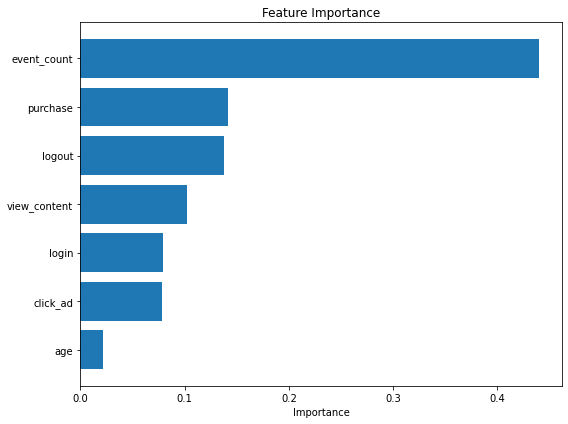

In [11]:
importances = model.feature_importances_
indices = np.argsort(importances)

sorted_features = np.array(feature_cols)[indices]
sorted_importances = importances[indices]

for f, imp in zip(sorted_features[::-1], sorted_importances[::-1]):
    print(f"{f:25s}  {imp:.4f}")

plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_features)), sorted_importances)
plt.yticks(range(len(sorted_features)), sorted_features)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## 7. Part 3 小结

本节基于用户表与事件表构建了一个用于预测用户是否为“活跃用户”的模型，主要工作包括：

1. 特征工程  
   - 通过聚合事件日志，构造了用户层面的行为特征，例如：  
     - 总事件次数 `event_count`  
     - 不同类型事件的次数（如浏览、点击、购买等）  
     - 首次事件距今的天数 `days_since_first_event`  
     - 是否曾发生过购买行为 `has_purchase`  
   - 将以上特征与用户属性（年龄等）结合，得到一张以用户为粒度的特征表。

2. 标签构造  
   - 依据总事件数量将用户划分为活跃 / 非活跃两类：`event_count > 10` 视为活跃用户。

3. 模型训练与评估  
   - 采用随机森林（Random Forest）模型，在训练集上完成训练，并在测试集上进行评估。  
   - 从分类报告可以看出，模型在区分活跃用户与非活跃用户方面具有一定的识别能力。

4. 特征重要性分析  
   - 通过特征重要性可以观察到：  
     - 总事件数量 `event_count` 与特定类型事件（如浏览、点击、购买）的次数是影响用户是否活跃的主要因素；  
     - “距首次事件的天数”等时间相关特征也对用户活跃度有一定贡献；  
     - 年龄等静态属性的重要性相对较低。

整体来看，该模型虽然相对简单，但已经展示了从行为日志中抽取特征、构建标签并进行预测建模的完整流程，为进一步优化用户运营策略提供了基础参考。
